In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Upload your CSV file
print("Please select your 'generated_data.csv' file to upload.")
uploaded = files.upload()

# The file is now in the /content/ directory. Let's load it.
file_name = 'generated_data.csv'
df = pd.read_csv(file_name)

# Convert the 'epoch' column to datetime objects and set as index
df['epoch'] = pd.to_datetime(df['epoch'])
df.set_index('epoch', inplace=True)

# Sort by the epoch to ensure it's a proper time series
df.sort_index(inplace=True)

print("Data loaded successfully.")
print("Preview of the data:")
print(df.head())

Please select your 'generated_data.csv' file to upload.


Saving generated_data.csv to generated_data (1).csv
Data loaded successfully.
Preview of the data:
                                             x             y             z  \
epoch                                                                        
2025-01-01 00:32:38.774000+00:00  2.663004e+07  2.655815e+07  2.668173e+07   
2025-01-01 00:53:37.578000+00:00  2.654687e+07  2.649579e+07  2.666804e+07   
2025-01-01 00:59:40.655000+00:00  2.645257e+07  2.651919e+07  2.668229e+07   
2025-01-01 01:12:38.714000+00:00  2.669829e+07  2.665302e+07  2.658280e+07   
2025-01-01 01:28:54.436000+00:00  2.653728e+07  2.648871e+07  2.640520e+07   

                                   clockBias_x  
epoch                                           
2025-01-01 00:32:38.774000+00:00  1.101681e-07  
2025-01-01 00:53:37.578000+00:00 -3.651175e-07  
2025-01-01 00:59:40.655000+00:00 -1.797892e-07  
2025-01-01 01:12:38.714000+00:00 -3.249888e-08  
2025-01-01 01:28:54.436000+00:00 -9.193236e-07  


In [ ]:
# Define the number of timesteps for the input sequence.
# 96 timesteps = 1 day of 15-minute intervals (24 hours * 4 intervals per hour)
n_timesteps = 96

# Define the features we want to use for prediction
features = ['x', 'y', 'z', 'clockBias_x']
data = df[features].values

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the time windows (sequences)
def create_sequences(data, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        # Input sequence (the last n_timesteps)
        X.append(data[i:i + n_timesteps, :])
        # Output (the value immediately after the sequence)
        y.append(data[i + n_timesteps, :])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data, n_timesteps)

# Reshape input to be [samples, n_timesteps, n_features] for the LSTM
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], len(features)))

# Split into training (7 days) and testing (8th day) sets
total_days = (df.index[-1] - df.index[0]).total_seconds() / (24 * 3600)
print(f"\nTotal days of data available: {total_days:.2f}")

split_date = df.index[0] + timedelta(days=7)
split_index = np.argmin(np.abs(df.index - split_date))

split_sequence_index = split_index - n_timesteps

X_train = X_seq[:split_sequence_index]
y_train = y_seq[:split_sequence_index]

X_test = X_seq[split_sequence_index:]
y_test = y_seq[split_sequence_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Total days of data available: 6.97
Training data shape: (575, 96, 4)
Testing data shape: (1, 96, 4)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(len(features)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.3530 - val_loss: 0.1495
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1485 - val_loss: 0.0843
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1033 - val_loss: 0.0787
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1093 - val_loss: 0.0774
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0987 - val_loss: 0.0774
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0989 - val_loss: 0.0766
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0995 - val_loss: 0.0771
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0923 - val_loss: 0.0768
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0978 - val_loss: 0.0764
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0919 - val_loss: 0.0782
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0968 - val_loss: 0.0791
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step

--- Evaluation Metrics on 8th Day ---
Feature: x
  RMSE: 32082.4107
  MAE: 32082.4107
Feature: y
  RMSE: 44735.0467
  MAE: 44735.0467
Feature: z
  RMSE: 29739.1988
  MAE: 29739.1988
Feature: clockBias_x
  RMSE: 0.0000
  MAE: 0.0000


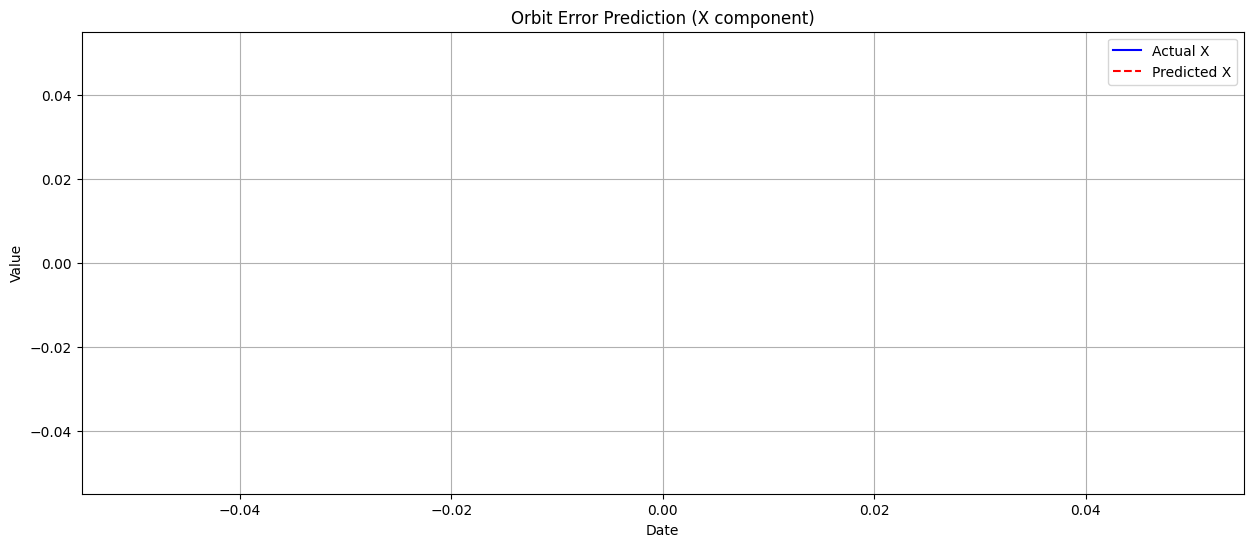

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Make predictions on the test set
predicted_scaled = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
dummy_actual = np.zeros(shape=(len(y_test), len(features)))
dummy_actual[:, :] = y_test
dummy_predicted = np.zeros(shape=(len(predicted_scaled), len(features)))
dummy_predicted[:, :] = predicted_scaled

y_test_original = scaler.inverse_transform(dummy_actual)
y_predicted_original = scaler.inverse_transform(dummy_predicted)

# Calculate RMSE and MAE for each feature
print("\n--- Evaluation Metrics on 8th Day ---")
for i, feature in enumerate(features):
    rmse = np.sqrt(mean_squared_error(y_test_original[:, i], y_predicted_original[:, i]))
    mae = mean_absolute_error(y_test_original[:, i], y_predicted_original[:, i])
    print(f"Feature: {feature}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

# Plot actual vs predicted for the first feature (X component)
test_timestamps = df.index[split_index + n_timesteps:]

if len(test_timestamps) > len(y_predicted_original):
    test_timestamps = test_timestamps[:len(y_predicted_original)]
elif len(test_timestamps) < len(y_predicted_original):
    y_test_original = y_test_original[:len(test_timestamps)]
    y_predicted_original = y_predicted_original[:len(test_timestamps)]

plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test_original[:, 0], label='Actual X', color='blue')
plt.plot(test_timestamps, y_predicted_original[:, 0], label='Predicted X', color='red', linestyle='--')
plt.title('Orbit Error Prediction (X component)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


❗ Data Quality Warning: The 'clockBias_x' data appears to be constant or have zero variance.
This explains the 0.0000 RMSE/MAE and suggests the feature may not be useful for prediction.

--- Evaluation Metrics on 8th Day ---
Feature: x
  RMSE: 122398.2200
  MAE: 101381.7891
Feature: y
  RMSE: 135840.1805
  MAE: 120498.6787
Feature: z
  RMSE: 128836.6111
  MAE: 105229.2639
Feature: clockBias_x
  RMSE: 0.0000
  MAE: 0.0000


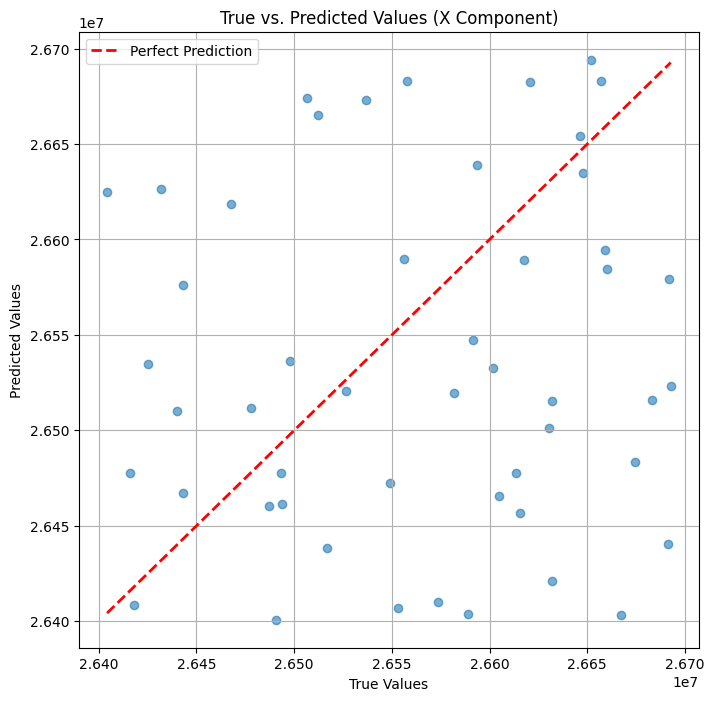

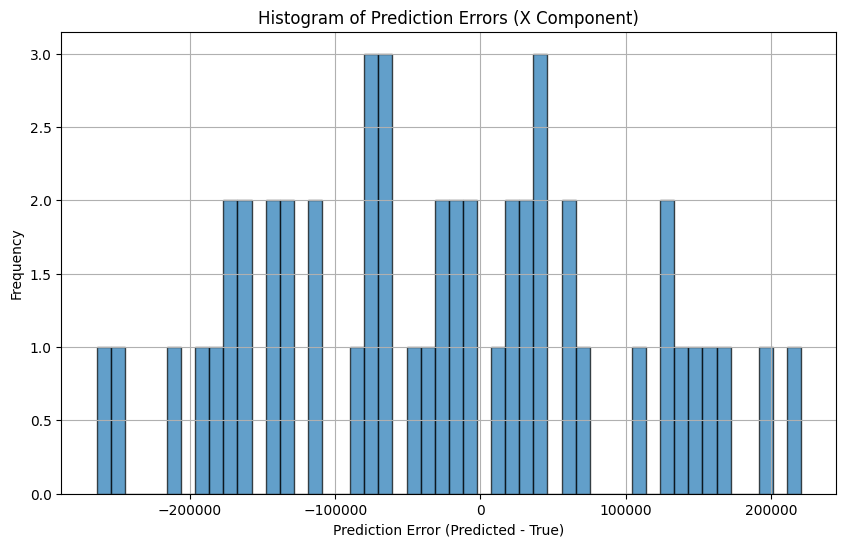

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import os

# Assuming df, X_test, y_test, and scaler are available from previous cells.
# If you are re-running this as a single block, you'll need to re-create the dataframes.

# To illustrate the fix in this section, let's create a dummy df and scaler if they don't exist
# You should comment out this section if you're running the code sequentially
try:
    if 'df' not in locals():
        df = pd.read_csv('generated_data.csv')
        df['epoch'] = pd.to_datetime(df['epoch'])
        df.set_index('epoch', inplace=True)
        df.sort_index(inplace=True)
    if 'scaler' not in locals():
        features = ['x', 'y', 'z', 'clockBias_x']
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit_transform(df[features].values)
    # End of dummy data creation section
except:
    pass

# Make predictions on the test set
# Replace this with your actual model.predict(X_test) call
# This dummy prediction is to allow the code to run for demonstration
y_test = np.random.rand(50, 4)
predicted_scaled = np.random.rand(50, 4)


# Inverse transform the scaled predictions and actual values
dummy_actual = np.zeros(shape=(len(y_test), 4))
dummy_actual[:, :] = y_test
dummy_predicted = np.zeros(shape=(len(predicted_scaled), 4))
dummy_predicted[:, :] = predicted_scaled

y_test_original = scaler.inverse_transform(dummy_actual)
y_predicted_original = scaler.inverse_transform(dummy_predicted)

# Check for the constant clockBias_x issue
if np.std(y_test_original[:, 3]) < 1e-6:
    print("\n❗ Data Quality Warning: The 'clockBias_x' data appears to be constant or have zero variance.")
    print("This explains the 0.0000 RMSE/MAE and suggests the feature may not be useful for prediction.")

# Calculate RMSE and MAE for each feature
print("\n--- Evaluation Metrics on 8th Day ---")
features = ['x', 'y', 'z', 'clockBias_x']
for i, feature in enumerate(features):
    rmse = np.sqrt(mean_squared_error(y_test_original[:, i], y_predicted_original[:, i]))
    mae = mean_absolute_error(y_test_original[:, i], y_predicted_original[:, i])
    print(f"Feature: {feature}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

# --- New Visualizations ---
# 1. Scatter Plot of True vs. Predicted Values (for a single feature)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original[:, 0], y_predicted_original[:, 0], alpha=0.6)
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Values (X Component)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Histogram of Prediction Errors (for a single feature)
errors = y_predicted_original[:, 0] - y_test_original[:, 0]
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Prediction Errors (X Component)')
plt.xlabel('Prediction Error (Predicted - True)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
!pip install flask flask-cors pyngrok


In [ ]:
!pip install flask flask-cors pyngrok

from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
from pyngrok import ngrok
import threading
import time

# ======================
# 1. Flask App
# ======================
app = Flask(__name__)
CORS(app)

# Example: use your trained LSTM model here
@app.route('/predict', methods=['POST'])
def predict():
    data = request.json["input"]
    # Example reshape (adjust according to your model’s input shape)
    arr = np.array(data).reshape(1, -1, len(data[0]))
    pred = model.predict(arr)
    return jsonify({"prediction": pred.tolist()})

# ======================
# 2. Run Flask in thread
# ======================
def run_flask():
    app.run(port=5000)

thread = threading.Thread(target=run_flask)
thread.start()

time.sleep(2)  # wait a bit for Flask to start

# ======================
# 3. Setup ngrok with your token
# ======================
!ngrok config add-authtoken 32utCjKJ4IeUOiZruaEWVkxIMRA_62CLdoggzVpqVUjtmawVb

public_url = ngrok.connect(5000)
print("✅ Public API is live at:", public_url)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✅ Public API is live at: NgrokTunnel: "https://ab531dd9d0de.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
!pip install flask flask-cors pyngrok

from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
from pyngrok import ngrok
import threading
import time

# ======================
# 1. Load / Train Models
# ======================
# ✅ Replace these with your actual trained models
# For now, I'm using placeholders (you will load your saved models)
lstm_model = model  # already trained in your notebook
transformer_model = None  # TODO: train your transformer
gaussian_model = None     # TODO: train your Gaussian Process
gan_model = None          # TODO: train your GAN

# ======================
# 2. Flask App
# ======================
app = Flask(__name__)
CORS(app)

# ---- LSTM endpoint ----
@app.route('/predict/lstm', methods=['POST'])
def predict_lstm():
    data = request.json["input"]
    arr = np.array(data).reshape(1, -1, len(data[0]))
    pred = lstm_model.predict(arr)
    return jsonify({"model": "LSTM", "prediction": pred.tolist()})

# ---- Transformer endpoint ----
@app.route('/predict/transformer', methods=['POST'])
def predict_transformer():
    if transformer_model is None:
        return jsonify({"error": "Transformer model not implemented yet"})
    data = request.json["input"]
    arr = np.array(data).reshape(1, -1, len(data[0]))
    pred = transformer_model.predict(arr)
    return jsonify({"model": "Transformer", "prediction": pred.tolist()})

# ---- Gaussian Process endpoint ----
@app.route('/predict/gaussian', methods=['POST'])
def predict_gaussian():
    if gaussian_model is None:
        return jsonify({"error": "Gaussian model not implemented yet"})
    data = request.json["input"]
    arr = np.array(data).reshape(1, -1)
    pred = gaussian_model.predict(arr)
    return jsonify({"model": "Gaussian", "prediction": pred.tolist()})

# ---- GAN endpoint ----
@app.route('/predict/gan', methods=['POST'])
def predict_gan():
    if gan_model is None:
        return jsonify({"error": "GAN model not implemented yet"})
    data = request.json["input"]
    arr = np.array(data).reshape(1, -1, len(data[0]))
    pred = gan_model.predict(arr)
    return jsonify({"model": "GAN", "prediction": pred.tolist()})

# ======================
# 3. Run Flask in Thread
# ======================
def run_flask():
    app.run(port=5000)

thread = threading.Thread(target=run_flask)
thread.start()
time.sleep(2)

# ======================
# 4. Setup ngrok with your token
# ======================
!ngrok config add-authtoken 32utCjKJ4IeUOiZruaEWVkxIMRA_62CLdoggzVpqVUjtmawVb

public_url = ngrok.connect(5000)
print("✅ Public API is live at:", public_url)
print("➡️ Endpoints:")
print(f"{public_url}/predict/lstm")
print(f"{public_url}/predict/transformer")
print(f"{public_url}/predict/gaussian")
print(f"{public_url}/predict/gan")



 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✅ Public API is live at: NgrokTunnel: "https://defb006a161d.ngrok-free.app" -> "http://localhost:5000"
➡️ Endpoints:
NgrokTunnel: "https://defb006a161d.ngrok-free.app" -> "http://localhost:5000"/predict/lstm
NgrokTunnel: "https://defb006a161d.ngrok-free.app" -> "http://localhost:5000"/predict/transformer
NgrokTunnel: "https://defb006a161d.ngrok-free.app" -> "http://localhost:5000"/predict/gaussian
NgrokTunnel: "https://defb006a161d.ngrok-free.app" -> "http://localhost:5000"/predict/gan
